# PokerML

In [1]:
# Disable some console warnings
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import numpy as np

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical

Make sure that you have Vivado suite in your environment.

In [3]:
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

## Configuration

In [4]:
DATA_DIR = "data"

MODELS_DIR = 'models/'
DATA_NPY_DIR = DATA_DIR + '/npy/Rank_npy/'

IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
TEST_SIZE = 0.2
NUM_CLASSES = 13

QKERAS_TRAIN = True ## I did not debug yet the issue with the QKeras saved model

## Load data

In [5]:
X_train_val = np.load(DATA_NPY_DIR + 'X_train_val.npy')
X_test = np.load(DATA_NPY_DIR + 'X_test.npy')
y_train_val = np.load(DATA_NPY_DIR + 'y_train_val.npy')
y_test = np.load(DATA_NPY_DIR + 'y_test.npy')
classes = np.load(DATA_NPY_DIR + 'classes.npy', allow_pickle=True)

In [6]:
print('Train and validation set:', X_train_val.shape[0])
print('Test set:                ', X_test.shape[0])
print('Classes:                 ', classes.shape[0])

Train and validation set: 7987
Test set:                 1997
Classes:                  13


## Train QKeras model

In [7]:
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Activation
from qkeras import QDense, QActivation, QConv2D
from qkeras.quantizers import quantized_bits, quantized_relu

# # ENABLE THIS IF YOU USE PRUNING
# from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
# from tensorflow_model_optimization.sparsity.keras import strip_pruning
# import tensorflow_model_optimization as tfmot

import pickle

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

In [11]:
CHECKPOINT_FILENAME = MODELS_DIR + 'qkeras/model.h5'

model = Sequential()

model.add(QConv2D(4,
                 kernel_size=(3, 3),
                 input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
                 kernel_quantizer=quantized_bits(6, 0, alpha=1),
                 bias_quantizer=quantized_bits(6, 0, alpha=1),
                 kernel_initializer='lecun_uniform',
                 kernel_regularizer=l1(0.0001),
                 name='conv1'))

model.add(QActivation(activation=quantized_relu(6),
                      name='relu1'))

model.add(MaxPooling2D(pool_size=(2, 2),
                       name='maxpool1'))

model.add(QConv2D(4,
                 kernel_size=(3, 3),
                 kernel_quantizer=quantized_bits(6, 0, alpha=1),
                 bias_quantizer=quantized_bits(6, 0, alpha=1),
                 kernel_initializer='lecun_uniform',
                 kernel_regularizer=l1(0.0001),
                 name='conv2'))

model.add(QActivation(activation=quantized_relu(6),
                      name='relu2'))

model.add(MaxPooling2D(pool_size=(2, 2),
                       name='maxpool2'))

model.add(Flatten(name='flatten'))

# model.add(QDense(32,
#                  kernel_quantizer=quantized_bits(6, 0, alpha=1),
#                  bias_quantizer=quantized_bits(6, 0, alpha=1),
#                  kernel_initializer='lecun_uniform',
#                  kernel_regularizer=l1(0.0001),
#                  name='dense1'))

# model.add(QActivation(activation=quantized_relu(6),
#                       name='relu3'))

model.add(QDense(NUM_CLASSES,
                 kernel_quantizer=quantized_bits(6, 0, alpha=1),
                 bias_quantizer=quantized_bits(6, 0, alpha=1),
                 kernel_initializer='lecun_uniform',
                 kernel_regularizer=l1(0.0001),
                 activation='softmax',
                 name='output'))


model.summary()
# # adding pruning 
# pruning_params = {
#     'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
#         initial_sparsity=0.50,
#         final_sparsity=0.80,
#         begin_step=200,
#         end_step=1000)
# }
# model = prune.prune_low_magnitude(model, **pruning_params)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (QConv2D)             (None, 62, 62, 4)         112       
                                                                 
 relu1 (QActivation)         (None, 62, 62, 4)         0         
                                                                 
 maxpool1 (MaxPooling2D)     (None, 31, 31, 4)         0         
                                                                 
 conv2 (QConv2D)             (None, 29, 29, 4)         148       
                                                                 
 relu2 (QActivation)         (None, 29, 29, 4)         0         
                                                                 
 maxpool2 (MaxPooling2D)     (None, 14, 14, 4)         0         
                                                                 
 flatten (Flatten)           (None, 784)              

In [12]:
if QKERAS_TRAIN:
    from qkeras.utils import model_save_quantized_weights

    # Using learning rate with exponential decay
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        0.001,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True
    )
    adam = Adam(learning_rate=lr_schedule)
    
    #adam = Adam(learning_rate=0.001)

    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

    # A few other callbacks. These should not give warnings on deprecated features.
    callbacks = [
            ModelCheckpoint(
                CHECKPOINT_FILENAME,
                monitor='val_loss',
                verbose=0,
                save_best_only=True,
                save_weights_only=False,
                save_freq='epoch')
       #,
       #pruning_callbacks.UpdatePruningStep()
       #,#ReduceLROnPlateau(patience=75, min_delta=1**-6), 
    ]

    history = model.fit(
        X_train_val,
        y_train_val,
        batch_size=128,
        epochs=40,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks
    )
    
# # Strip the model of pruning information
#     model = strip_pruning(model)
#    model.save(CHECKPOINT_FILENAME)

    # Use this instead if you use the callbacks
    history_file = CHECKPOINT_FILENAME.replace('.h5', '-history.pkl')
    with open(history_file, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    print(f'Saving history to: {history_file}')
    print(f'Saved checkpoint to: {CHECKPOINT_FILENAME}')


else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model(CHECKPOINT_FILENAME, custom_objects=co, compile=False)

Epoch 1/40
47/47 [==============================] - 7s 115ms/step - loss: 2.5688 - accuracy: 0.1275 - val_loss: 2.3963 - val_accuracy: 0.2499
Epoch 2/40
47/47 [==============================] - 4s 96ms/step - loss: 2.0074 - accuracy: 0.4349 - val_loss: 1.6251 - val_accuracy: 0.5884
Epoch 3/40
47/47 [==============================] - 5s 98ms/step - loss: 1.3265 - accuracy: 0.7134 - val_loss: 1.1007 - val_accuracy: 0.7777
Epoch 4/40
47/47 [==============================] - 4s 94ms/step - loss: 0.9206 - accuracy: 0.8279 - val_loss: 0.8077 - val_accuracy: 0.8307
Epoch 5/40
47/47 [==============================] - 4s 92ms/step - loss: 0.7037 - accuracy: 0.8716 - val_loss: 0.6476 - val_accuracy: 0.8688
Epoch 6/40
47/47 [==============================] - 4s 96ms/step - loss: 0.5682 - accuracy: 0.9068 - val_loss: 0.5362 - val_accuracy: 0.9039
Epoch 7/40
47/47 [==============================] - 4s 94ms/step - loss: 0.4815 - accuracy: 0.9182 - val_loss: 0.4760 - val_accuracy: 0.9059
Epoch 8/40
4

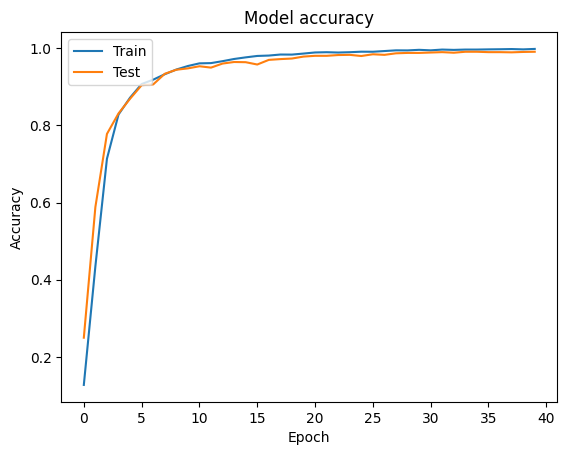

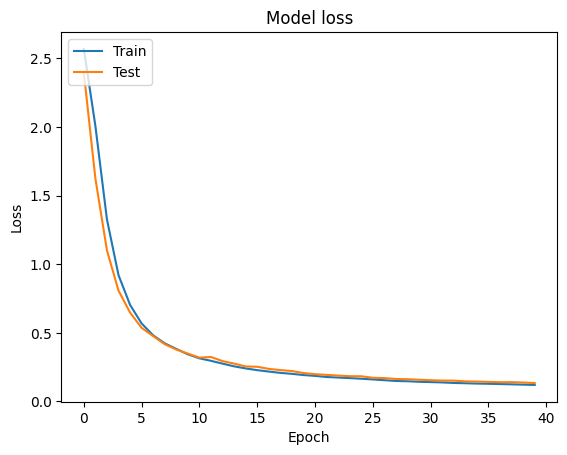

In [13]:
if QKERAS_TRAIN:
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Test')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

In [21]:
y_qkeras = model.predict(np.ascontiguousarray(X_test))

print("QKeras accuracy: {:.6f}%".format(100.*accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))

63/63 [==============================] - 1s 14ms/step
QKeras accuracy: 99.399099%


Pre trained model sul have accuracy = 98.030708%

## QKeras to hls4ml (Quantization Aware Training)

In [51]:
import hls4ml
import plotting

# Then the QKeras model
hls_config_q = hls4ml.utils.config_from_keras_model(model, granularity='name')
hls_config_q['Model']['ReuseFactor'] = 256
hls_config_q['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config_q['LayerName']['output']['Strategy'] = 'Stable'
hls_config_q['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config_q['Model']['Strategy'] = 'Resource'

plotting.print_dict(hls_config_q)

cfg_q = hls4ml.converters.create_config(backend='VivadoAccelerator')
cfg_q['IOType'] = 'io_stream'  # Must set this if using CNNs!
cfg_q['HLSConfig'] = hls_config_q
cfg_q['KerasModel'] = model
cfg_q['OutputDir'] = 'projects/qat_hls4ml_prj_rank'
# cfg_q['XilinxPart'] = 'xczu5ev-sfvc784-2LV-e'

hls_model_q = hls4ml.converters.keras_to_hls(cfg_q)
hls_model_q.compile()

Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, input shapes: [[None, 64, 64, 3]], output shape: [None, 64, 64, 3]
Layer name: conv1, layer type: QConv2D, input shapes: [[None, 64, 64, 3]], output shape: [None, 62, 62, 4]
Layer name: relu1, layer type: Activation, input shapes: [[None, 62, 62, 4]], output shape: [None, 62, 62, 4]
Layer name: maxpool1, layer type: MaxPooling2D, input shapes: [[None, 62, 62, 4]], output shape: [None, 31, 31, 4]
Layer name: conv2, layer type: QConv2D, input shapes: [[None, 31, 31, 4]], output shape: [None, 29, 29, 4]
Layer name: relu2, layer type: Activation, input shapes: [[None, 29, 29, 4]], output shape: [None, 29, 29, 4]
Layer name: maxpool2, layer type: MaxPooling2D, input shapes: [[None, 29, 29, 4]], output shape: [None, 14, 14, 4]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 14, 14, 4]], output shape: [None, 784]
Layer name: output, layer type: QDense, input shapes: [[None, 784]], output shape: 

In [46]:
# IF PREDICTION TAKE TOO MUCH PLEASE
# REDUCE THE NUMBER OF INPUTS
print(X_test.shape)
print(X_test[:10].shape)

(1997, 64, 64, 3)
(10, 64, 64, 3)


In [52]:
y_qkeras = model.predict(np.ascontiguousarray(X_test))
y_hls = hls_model_q.predict(np.ascontiguousarray(X_test))

63/63 [==============================] - 1s 15ms/step


In [53]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

#print("Accuracy baseline:  {:.6f}%".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("Accuracy quantized: {:.6f}%".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml:    {:.6f}%".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

Accuracy quantized: 0.993991%
Accuracy hls4ml:    0.993991%


```
With pretrained model you should expect:
Accuracy quantized: 0.980307%
Accuracy hls4ml:    0.979973%
```

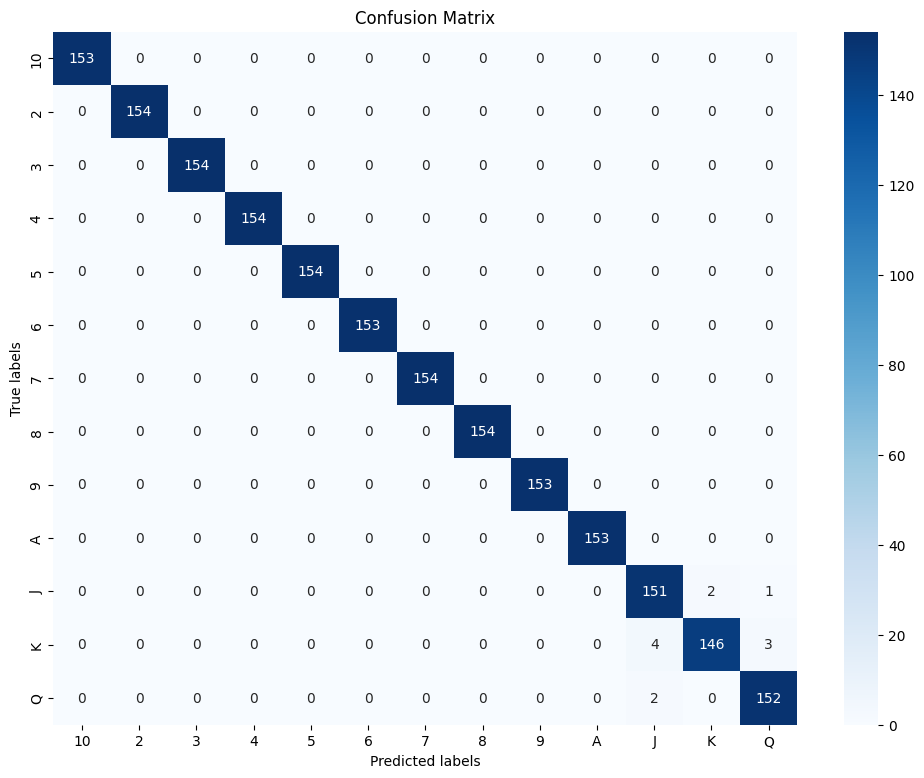

In [54]:
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using seaborn's heatmap.
    
    Args:
        cm (array, shape = [n, n]): Confusion matrix
        class_names (array, shape = [n]): Array of class names
    """
    plt.figure(figsize=(12, 9))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

y_test_ = np.argmax(y_test, axis=1)
y_qkeras_ = np.argmax(y_qkeras, axis=1)

cm = confusion_matrix(y_test_, y_qkeras_)

plot_confusion_matrix(cm, classes)

In [55]:
import os

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

#hls_model_q.build(csim=False, synth=False, vsynth=True, cosim = False, bitfile = True)
hls_model_q.build(csim=False, synth=True, vsynth=False)



****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /opt/xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/opt/xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'rht2122' on host 'socp06-ubuntu.c.psyched-span-141520.internal' (Linux_x86_64 version 5.4.0-1106-gcp) on Tue Apr 09 21:16:11 UTC 2024
INFO: [HLS 200-10] On os Ubuntu 18.04.6 LTS
INFO: [HLS 200-10] In directory '/home/esp2024/rht2122/PokerML/PokerML/projects/qat_hls4ml_prj_rank'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/esp2024/rht2122/PokerML/PokerML/projects/qat_hls4ml_prj_rank/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject_axi.cpp' 

INFO: [HLS 200-111] Finished Standard Transforms Time (s): cpu = 00:01:04 ; elapsed = 00:01:08 . Memory (MB): peak = 965.348 ; gain = 532.145 ; free physical = 13051 ; free virtual = 33084
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [XFORM 203-602] Inlining function 'nnet::Op_max<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0> >::operator()' into 'nnet::reduce<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 2, nnet::Op_max<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0> > >' (firmware/nnet_utils/nnet_common.h:43) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::reduce<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 2, nnet::Op_max<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0> > >' into 'nnet::reduce<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 4, nnet::Op_max<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0> > >' (firmware/nnet_utils/nnet_common.h:45) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::Op_max<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 

INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::softmax_stable<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 13u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 13u>, softmax_config12>' (firmware/nnet_utils/nnet_activation_stream.h:193:47).
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'ReLUActLoop' (firmware/nnet_utils/nnet_activation_stream.h:41) in function 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 4u>, nnet::array<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, 4u>, relu_config8>' for pipelining.
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'ReLUActLoop' (firmware/nnet_utils/nnet_activation_stream.h:41) in function 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 4u>, nnet::array<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, 4u>, relu_config4>' for pipelining.
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'ReadInputWidth' (firmware/nnet

INFO: [HLS 200-489] Unrolling loop 'UpdateBuffer' (firmware/nnet_utils/nnet_conv_stream.h:233) in function 'nnet::pooling2d_cl<nnet::array<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, 4u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 4u>, config5>' completely with a factor of 4.
INFO: [HLS 200-489] Unrolling loop 'LineBufferDataIn' (firmware/nnet_utils/nnet_conv_stream.h:241) in function 'nnet::pooling2d_cl<nnet::array<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, 4u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 4u>, config5>' completely with a factor of 4.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftWidth' (firmware/nnet_utils/nnet_conv_stream.h:194) in function 'nnet::pooling2d_cl<nnet::array<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, 4u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 4u>, config5>' completely with a factor of 1.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftHeight' (firmware/nnet_utils/nnet_conv_stream.h:197

INFO: [HLS 200-489] Unrolling loop 'KernelPushHeight' (firmware/nnet_utils/nnet_conv_stream.h:210) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, config2>' completely with a factor of 3.
INFO: [HLS 200-489] Unrolling loop 'KernelPushChannel' (firmware/nnet_utils/nnet_conv_stream.h:213) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, config2>' completely with a factor of 3.
INFO: [XFORM 203-102] Partitioning array 'd_xi_xmax.V' (firmware/nnet_utils/nnet_activation_stream.h:212) automatically.
INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V.3' .
INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V.2' .
INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V.1' .
INFO: [XFORM 203-102] Automatically partitioning shift register array 'line_buffer.Array.V' .
INFO: [XFORM

{}

In [ ]:
hls4ml.report.read_vivado_report('projects/qat_hls4ml_prj')